In [0]:
import scipy.io as sio
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import matplotlib.patches as patches
import os
import glob
import cv2
import csv
import random

import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms, utils
from tqdm import tqdm
from torch import nn, optim
from torchsummary import summary
from torch.autograd import Variable

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
temp = np.zeros(40).reshape((5,8))
temp[:,4] = 255.
wh = np.zeros(temp.shape)
print(wh.shape)

(5, 8)


# Preprocess CSV annotation file


In [0]:
dirPath = '/content/drive/My Drive/multicars_images/'
anns = {}
with open(dirPath+'annotation/labels_crowdai.csv') as f:
    csv_reader = csv.reader(f, delimiter=",")
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            print(f'Column names are {", ".join(row)}')
        else:
            fname = row[4].strip()
            if row[4] in anns:
                anns[fname].append([int(xy) for xy in row[:4]])
            else:
                anns[fname] = [[int(xy) for xy in row[:4]]]
        line_count += 1
    print('Total {} lines were processed'.format(line_count))

Column names are xmin, ymin, xmax, ymax, Frame, Label, Preview URL
Total 72065 lines were processed


In [0]:
print(anns['1479499031508279949.jpg'])

KeyError: ignored

# Generate binary images

In [0]:
type_ = 'train'

images = glob.glob(dirPath + type_ + '/images/*.jpg')
masks = {}
count = 0
for img_path in images[411:]:
    fname = os.path.basename(img_path)

    if not fname in anns:
        # raise Exception('Annotation for {} not found'.format(fname))
        print(fname)
    else:
        coords = anns[fname]

        img = np.array(Image.open(img_path))

        if fname in masks:
            mask_img = masks[fname]
        else:
            mask_img = np.zeros(img.shape[:2])
        
        # if len(coords) > 1:
            # print(coords)
        for coord in coords:
            mask_img[coord[1]:coord[-1], coord[0]:coord[2]] = 255.0
        # else:
        #     mask_img[coords[1]:coords[-1], coords[0]:coords[2]] = 255.0
        
        masks[fname] = mask_img
        count += 1
print('Total {} binary images generated'.format(count))

1479499031508279949.jpg
1479499034508858197.jpg
1479499034008524854.jpg
1479499033009421908.jpg
1479499032008420832.jpg
1479499037009190675.jpg
1479499032509365899.jpg
1479499038009080682.jpg
1479499035008874253.jpg
1479499035509075812.jpg
1479499036508994225.jpg
1479499039012143867.jpg
1479499040011657995.jpg
1479499044510144590.jpg
1479499042511667406.jpg
1479499046510660592.jpg
1479499045010549365.jpg
1479499045994762285.jpg
1479499043511856331.jpg
1479499047509504683.jpg
1479499049511867206.jpg
1479499048009663080.jpg
1479499048509667745.jpg
1479499049009777691.jpg
1479499050509622667.jpg
1479499052510029904.jpg
1479499053510074792.jpg
1479499051009786675.jpg
1479499051510146504.jpg
Total 421 binary images generated


# Save mask images

In [0]:
bimgs = list(masks.items())
for item in bimgs:
    # print(dirPath + type_ + '/masks/' + item[0])
    plt.imsave(dirPath + type_ + '/masks/' + item[0], item[1])

# Setup Dataset

In [0]:
class SegmentationDataset(Dataset):
    def __init__(self, train_path, mask_path, augmentation=False):
        self.train_path = train_path
        self.mask_path = mask_path
        self.augmentation = augmentation
    
        self.train_imgs, self.mask_imgs = self._load_images()

        if not self.train_imgs or not self.mask_imgs:
            raise Exception("File path not exist: " + train_path + ' or ' + mask_path)

    def _load_images(self):
        print(os.path.join(self.train_path, "*.jpg"))
        print(os.path.join(self.mask_path, "*.jpg"))
        train_files = sorted(glob.glob(os.path.join(self.train_path, "*.jpg")))
        mask_files = sorted(glob.glob(os.path.join(self.mask_path, "*.jpg")))

        # print(len(train_files), len(mask_files))
        # print(sorted(list(set(train_files) - set(mask_files))))
        tr = [os.path.basename(name) for name in train_files]
        mk = [os.path.basename(name) for name in mask_files]

        print(len(train_files), len(mask_files))
        print(sorted(list(set(tr)-set(mk))))
        
        assert(len(train_files) == len(mask_files))
        
        train_imgs, mask_imgs = [], []

        for i in range(len(train_files)):
            trn = Image.open(train_files[i])
            mask = Image.open(mask_files[i])

            train_imgs.append(trn)
            mask_imgs.append(mask)
        return train_imgs, mask_imgs 

    def __getitem__(self, i):
        img = self.train_imgs[i]
        mask = self.mask_imgs[i]

        size = 256

        resize = transforms.Compose([transforms.Resize((size, size)),
                                    transforms.ToTensor()])
        brightness = transforms.Compose([transforms.ToPILImage(),
                                         transforms.Resize((size, size)),
                                         transforms.ColorJitter(2),
                                         transforms.ToTensor()])
        randRotate = transforms.Compose([transforms.ToPILImage(),
                                         transforms.Resize((size, size)),
                                         transforms.RandomRotation((-180,180)),
                                         transforms.ToTensor()])
        randomcrop = transforms.Compose([transforms.ToPILImage(),
                                         transforms.RandomCrop(size),
                                         transforms.ToTensor()])
        
        resize_m = transforms.Compose([transforms.Resize((size, size)),
                                       transforms.Grayscale(num_output_channels=1),
                                    transforms.ToTensor()])
        brightness_m = transforms.Compose([transforms.ToPILImage(),
                                           transforms.Resize((size, size)),
                                           transforms.Grayscale(num_output_channels=1),
                                         transforms.ColorJitter(2),
                                         transforms.ToTensor()])
        randRotate_m = transforms.Compose([transforms.ToPILImage(),
                                           transforms.Resize((size, size)),
                                         transforms.RandomRotation((-180,180)),
                                         transforms.Grayscale(num_output_channels=1),
                                         transforms.ToTensor()])
        randomcrop_m = transforms.Compose([transforms.ToPILImage(),
                                           transforms.RandomCrop(size),
                                           transforms.Grayscale(num_output_channels=1),
                                           transforms.ToTensor()])
        
        techniques_img = [brightness, randRotate, randomcrop]
        techniques_mask = [brightness_m,randRotate_m,randomcrop_m]

        img = resize(img)
        mask = resize_m(mask)

        if self.augmentation:
            seed_num = random.randint(20,60)
            i = random.randint(0, len(techniques_img)-1)
            random.seed(seed_num)
            img = techniques_img[i](img)
            random.seed(seed_num)
            mask = techniques_mask[i](mask)

        return img, mask 
    
    def __len__(self):
        return len(self.train_imgs)

# UNet

In [0]:
class UNet(nn.Module):
    def __init__(self, in_c, out_c):
        super(UNet, self).__init__()

        # contracting
        self.down1 = self.contractingPath(in_c, 64)
        self.down1_1 = self.maxpooling()

        self.down2 = self.contractingPath(64, 128)
        self.down2_1 = self.maxpooling()

        self.down3 = self.contractingPath(128, 256)
        self.down3_1 = self.maxpooling()

        self.down4 = self.contractingPath(256, 512)
        self.down4_1 = self.maxpooling()

        # expanding
        self.bottom = self.expandingPath(512, 1024)
        self.up1_1 = self.convTranspose(1024, 512)

        self.up2 = self.expandingPath(1024, 512)
        self.up2_1 = self.convTranspose(512, 256)

        self.up3 = self.expandingPath(512, 256)
        self.up3_1 = self.convTranspose(256, 128)

        self.up4 = self.expandingPath(256, 128)
        self.up4_1 = self.convTranspose(128, 64)

        self.last = self.finalStep(128, 64)

    def contractingPath(self, in_c, out_c):
        down_layer = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU())
        return down_layer
    
    def maxpooling(self):
        maxpooling_layer = nn.Sequential(
            nn.MaxPool2d(2)
        )
        return maxpooling_layer

    def expandingPath(self, in_c, out_c):
        up_layer = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU())
        return up_layer
    
    def convTranspose(self, in_c, out_c):
        expand_layer = nn.Sequential(
            nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2)
        )
        return expand_layer

    def finalStep(self, in_c, out_c):
        last_layer = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(),
            nn.Conv2d(out_c, 1, kernel_size=1))
        return last_layer

    def forward(self, x):
        contracting1 = self.down1(x)    
        c1_1 = self.down1_1(contracting1) 

        contracting2 = self.down2(c1_1)
        c2_1 = self.down2_1(contracting2)

        contracting3 = self.down3(c2_1)
        c3_1 = self.down3_1(contracting3)

        contracting4 = self.down4(c3_1)
        c4_1 = self.down4_1(contracting4)
        
        bottom_layer = self.bottom(c4_1)
        upsampling1 = self.up1_1(bottom_layer) 
        
        concat4 = torch.cat([upsampling1, contracting4], dim=1)  
        upsampling2 = self.up2(concat4) 
        halved3 = self.up2_1(upsampling2)
        
        concat3 = torch.cat([halved3, contracting3], dim=1) 
        upsampling3 = self.up3(concat3) 
        halved2 = self.up3_1(upsampling3) 

        concat2 = torch.cat([halved2, contracting2], dim=1) 
        upsampling2 = self.up4(concat2) 
        havled1 = self.up4_1(upsampling2) 

        concat1 = torch.cat([havled1, contracting1], dim=1) 
        out = self.last(concat1)
        
        return torch.sigmoid(out)

# Load dataset

In [0]:
def loadDataset():
    train_path = r"/content/drive/My Drive/multicars_images/train/"
    test_path = r"/content/drive/My Drive/multicars_images/test/"
    trainset = SegmentationDataset(train_path + "images", train_path + "masks")
    testset = SegmentationDataset(test_path+"images", test_path+"masks")

    trainLoader = torch.utils.data.DataLoader(trainset, batch_size=6, shuffle=True)
    testLoader = torch.utils.data.DataLoader(testset, batch_size=6, shuffle=False)
    return trainLoader, testLoader

In [0]:
trainLoader, testloader = loadDataset()

/content/drive/My Drive/multicars_images/train/images/*.jpg
/content/drive/My Drive/multicars_images/train/masks/*.jpg
411 411
[]
/content/drive/My Drive/multicars_images/test/images/*.jpg
/content/drive/My Drive/multicars_images/test/masks/*.jpg
53 53
[]


# Train

In [0]:
def diceLoss(y_pred, target):
    smooth = 1.
    samples = y_pred.shape[0]
    y_pred = y_pred.view(samples, -1)
    target = target.view(samples, -1)
    intersection = (y_pred * target).sum()

    loss = 2. * (intersection + smooth) / (y_pred.sum()+target.sum() + smooth)
    return 1 - loss

def trainNetwork(model, trainloader):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    epochs = 20

    training_losses = []

    count = 0

    for e in range(epochs):
        running_loss = 0

        for images, labels in trainloader:
            images = images.to(device)
            labels = labels.to(device)

            pred = model(images)

            loss = diceLoss(pred, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            count += 1

            running_loss += loss.item()
        print("Epoch: {}/{}..".format(e+1, epochs),
              "Training loss: {:.3f}..".format(running_loss/len(trainloader)))

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
model = UNet(3,64)
model = model.to(device)

In [0]:
trainNetwork(model, trainLoader)
# torch.save(model.state_dict(), "/content/drive/My Drive/Colab Notebooks/carSeg.pt")

Epoch: 1/20.. Training loss: 0.688..
Epoch: 2/20.. Training loss: 0.656..
Epoch: 3/20.. Training loss: 0.624..
Epoch: 4/20.. Training loss: 0.611..
Epoch: 5/20.. Training loss: 0.605..
Epoch: 6/20.. Training loss: 0.597..
Epoch: 7/20.. Training loss: 0.600..
Epoch: 8/20.. Training loss: 0.588..
Epoch: 9/20.. Training loss: 0.588..
Epoch: 10/20.. Training loss: 0.585..
Epoch: 11/20.. Training loss: 0.586..
Epoch: 12/20.. Training loss: 0.581..
Epoch: 13/20.. Training loss: 0.580..
Epoch: 14/20.. Training loss: 0.585..
Epoch: 15/20.. Training loss: 0.581..
Epoch: 16/20.. Training loss: 0.580..
Epoch: 17/20.. Training loss: 0.579..
Epoch: 18/20.. Training loss: 0.580..
Epoch: 19/20.. Training loss: 0.576..
Epoch: 20/20.. Training loss: 0.573..


# Evaluate model

In [0]:
def display_result(img, label, pred):
    img = img.permute(1,2,0).squeeze().cpu().numpy()
    label = label.permute(1,2,0).squeeze().cpu().numpy()
    pred_one = pred.permute(1,2,0).squeeze().cpu().numpy()

    fig, ax = plt.subplots(1,3)
    ax[0].imshow(img)
    ax[1].imshow(img)
    ax[1].imshow(label, alpha=0.5)
    ax[2].imshow(img)
    ax[2].imshow(pred_one,alpha=0.5) #cmap='gray', 
    fig.tight_layout()
    plt.show()

In [0]:
def evaluation(model, testLoader):
    test_loss = 0
    accuracy = 0
    model.eval()

    results = []
    with torch.no_grad():
        for test_img, test_label in testLoader:
            test_img, test_label = test_img.to(device), test_label.to(device)
            test_pred = model(test_img)
            
            test_loss += diceLoss(test_pred, test_label)
            accuracy += (2. * (test_pred * test_label).sum() + 1) / (test_pred.sum() + test_label.sum() + 1)
            for i in range(len(test_img)):
                results.append((test_img[i], test_pred[i]))
                display_result(test_img[i], test_label[i], test_pred[i])
    print('Test Loss: {:.3f}.. '.format(test_loss/len(testLoader)), 'Test accuracy: {:.3f}..'.format(accuracy/len(testLoader)))
    return results

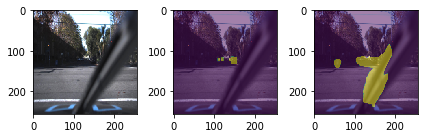

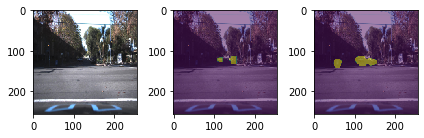

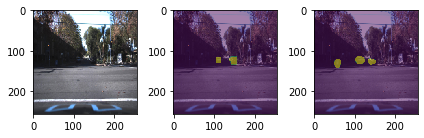

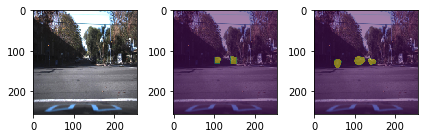

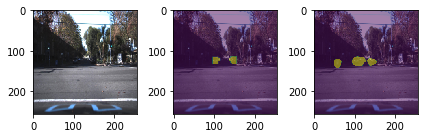

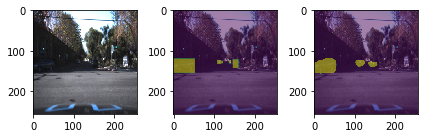

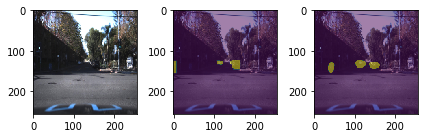

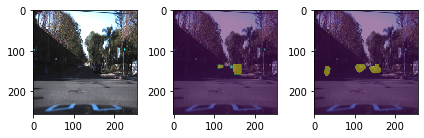

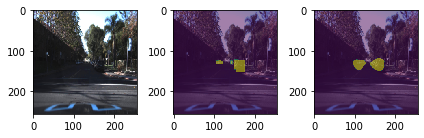

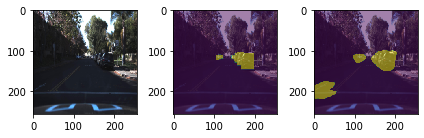

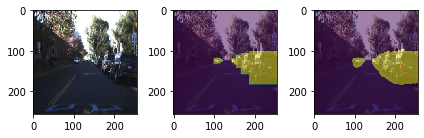

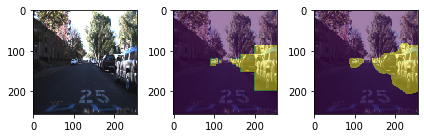

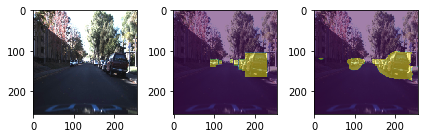

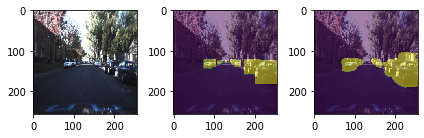

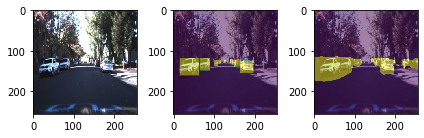

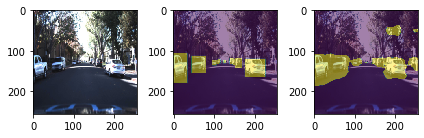

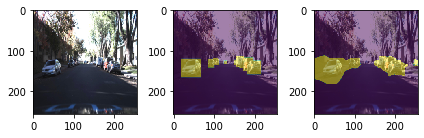

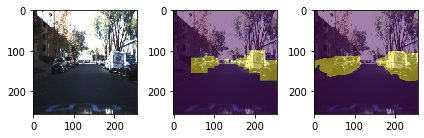

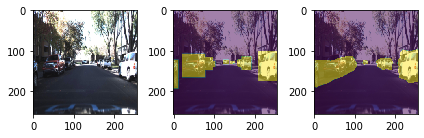

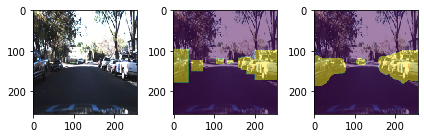

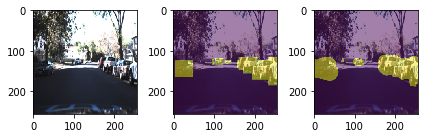

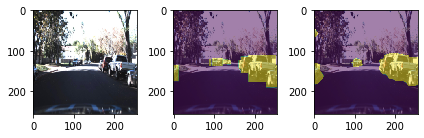

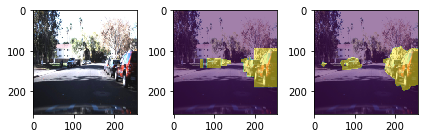

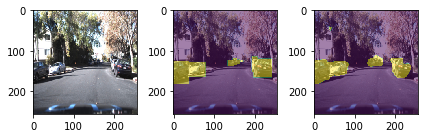

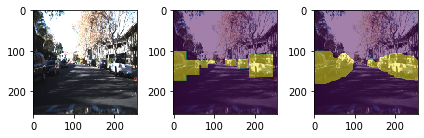

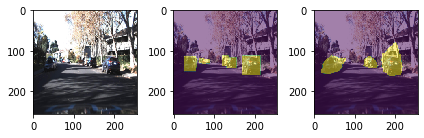

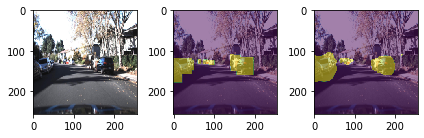

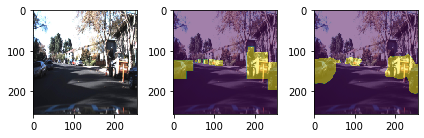

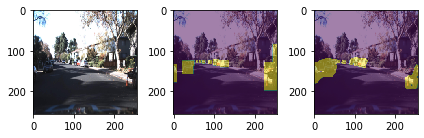

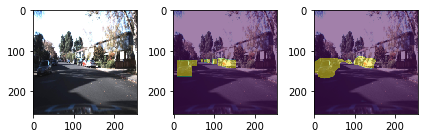

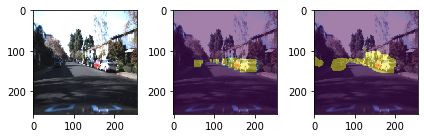

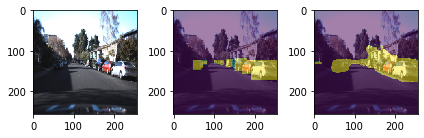

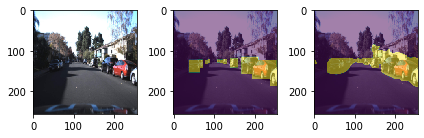

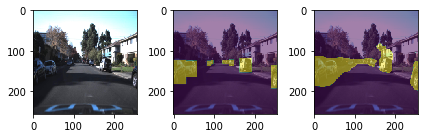

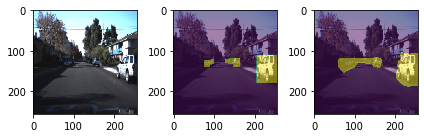

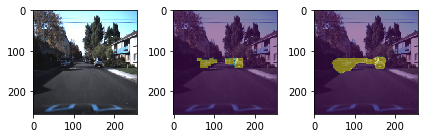

Test Loss: 0.578..  Test accuracy: 0.422..


In [0]:
test_results = evaluation(model, testloader)

# Data augmentation

In [0]:
model = UNet(3,64)
model = model.to(device)

train_path = r"/content/drive/My Drive/multicars_images/train/"
test_path = r"/content/drive/My Drive/multicars_images/test/"

trainset = SegmentationDataset(train_path + "images", train_path + "masks", True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=6, shuffle=True)
trainNetwork(model, trainloader)

torch.save(model.state_dict(), "/content/drive/My Drive/Colab Notebooks/carSeg_aug2.pt")

/content/drive/My Drive/multicars_images/train/images/*.jpg
/content/drive/My Drive/multicars_images/train/masks/*.jpg
411 411
[]
Epoch: 1/20.. Training loss: 0.605..
Epoch: 2/20.. Training loss: 0.579..
Epoch: 3/20.. Training loss: 0.571..
Epoch: 4/20.. Training loss: 0.569..
Epoch: 5/20.. Training loss: 0.564..
Epoch: 6/20.. Training loss: 0.565..
Epoch: 7/20.. Training loss: 0.557..
Epoch: 8/20.. Training loss: 0.554..
Epoch: 9/20.. Training loss: 0.555..
Epoch: 10/20.. Training loss: 0.560..
Epoch: 11/20.. Training loss: 0.555..
Epoch: 12/20.. Training loss: 0.554..
Epoch: 13/20.. Training loss: 0.560..
Epoch: 14/20.. Training loss: 0.555..
Epoch: 15/20.. Training loss: 0.553..
Epoch: 16/20.. Training loss: 0.554..
Epoch: 17/20.. Training loss: 0.551..
Epoch: 18/20.. Training loss: 0.555..
Epoch: 19/20.. Training loss: 0.553..
Epoch: 20/20.. Training loss: 0.549..


In [0]:
model.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/carSeg_aug2.pt'))

testset = SegmentationDataset(test_path+"images", test_path+"masks")
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False)

/content/drive/My Drive/multicars_images/test/images/*.jpg
/content/drive/My Drive/multicars_images/test/masks/*.jpg
53 53
[]


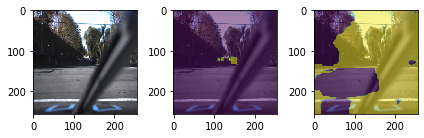

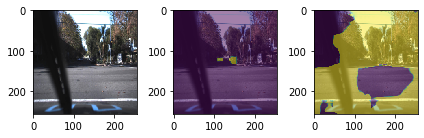

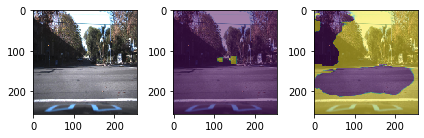

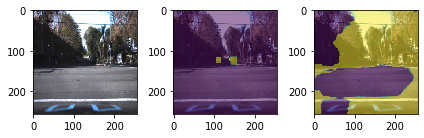

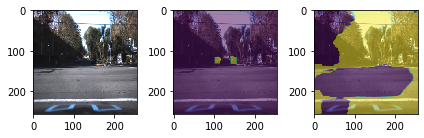

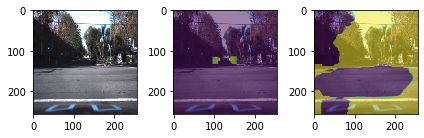

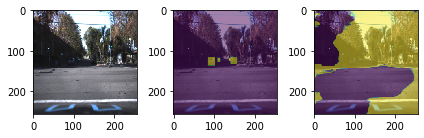

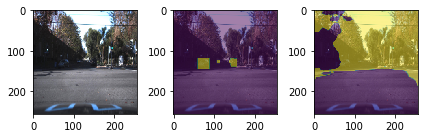

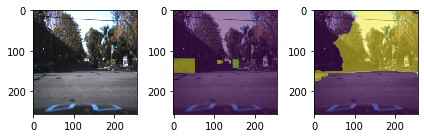

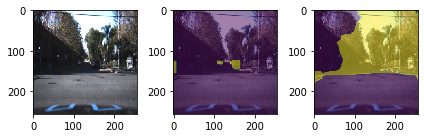

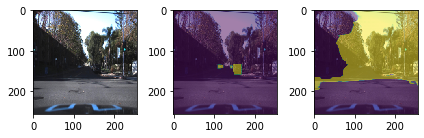

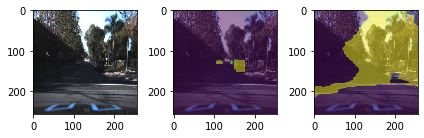

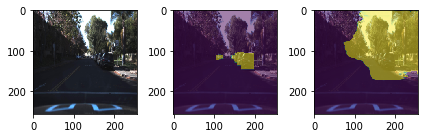

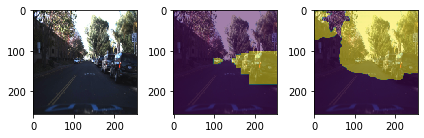

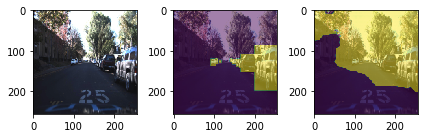

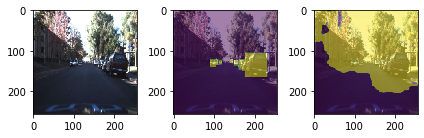

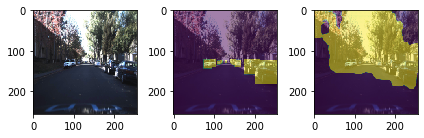

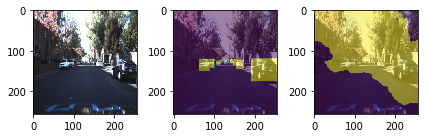

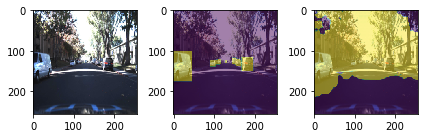

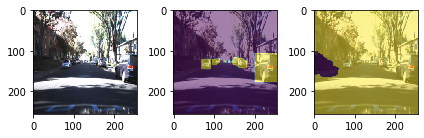

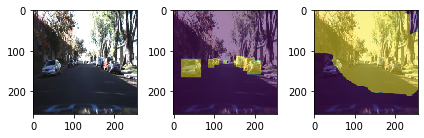

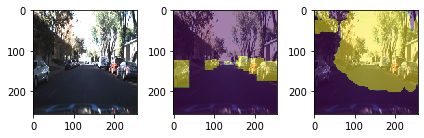

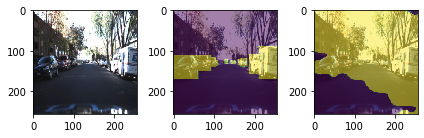

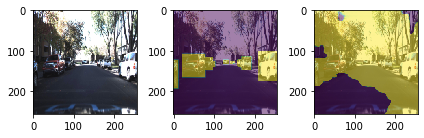

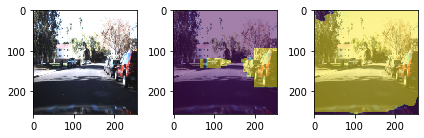

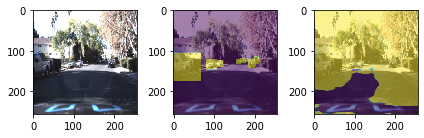

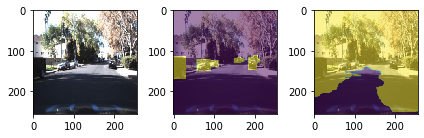

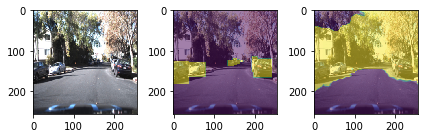

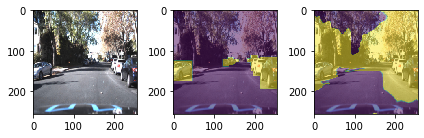

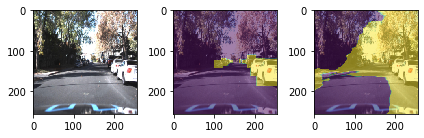

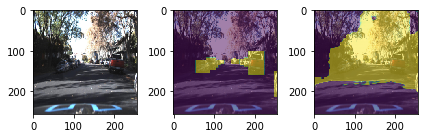

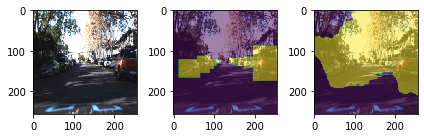

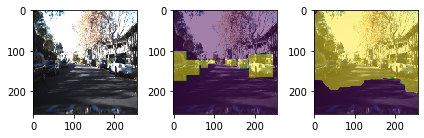

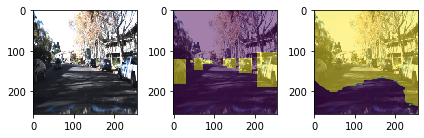

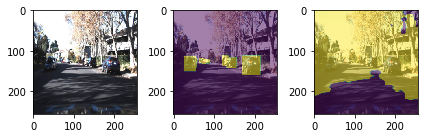

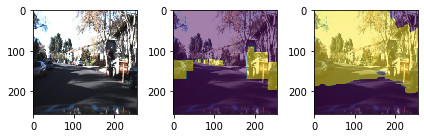

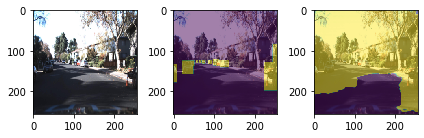

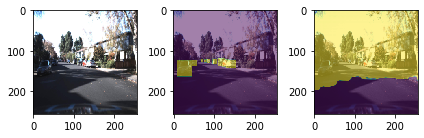

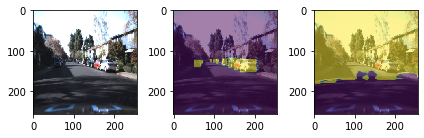

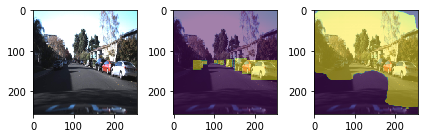

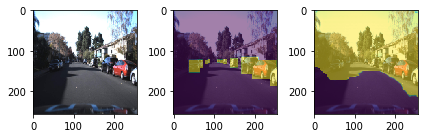

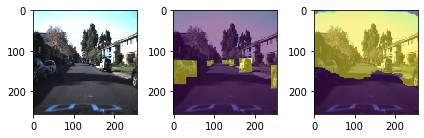

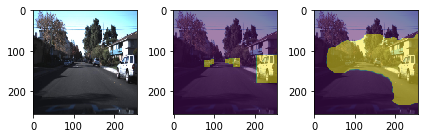

Test Loss: 0.695..  Test accuracy: 0.305..


In [0]:
test_augresults = evaluation(model, testloader)